# Giacomo Menegatti Homework 6
## LAGEOS satellite orbit propagation
For this work I found a different library than pysofa which is pyerfa (Essential Routines for Fundamental Astronomy) based on SOFA, which I found more complete.

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
import erfa


### Associated Legendre Functions table of coefficients
The coefficients are calculated by the relations $$f_n = \sqrt{(1+\delta_{1n})\frac{2n+1}{2n}} $$
$$ g^m_n =\sqrt{\frac{(2n+1)(2n-1)}{(n+m)(n-m)}} $$
$$ h_n^m = \frac{g_n^m}{g^m_{n-1}} $$
$$ f'_n=\sqrt{\frac{n(n+1)}{2}} $$
$$ k_n^m = \frac{1}{2}\sqrt{(n-m)(n+m+1)} $$
$$ l_n^m = \frac{1}{2}\sqrt{(1+\delta_{1m})(n+m)(n-m+1)} $$ 

The Legendre functions are calculated with the recurrent relationships

$$ P_n^n(\sin \phi) = f_n \cos \phi P^{n-1}_{n-1}(\sin \phi) $$
$$ P_n^{n-1}(\sin \phi) = g_n^m \sin \phi P^{n-1}_{n-1}(\sin \phi) $$
$$ P_n^m(\sin \phi) = g_n^m \sin \phi P^{m}_{n-1}(\sin \phi) - h^m_n P^{m}_{n-2}(\sin \phi)$$
$$ \partial_\phi P_n(\sin \phi) = f'_n P_n^1(\sin \phi) $$
$$ \partial_\phi P_n^m(\sin \phi) = k_n^m P_n^{m+1}(\sin \phi)-l_n^m P_n^{m-1}(\sin \phi) $$

The functions and the coefficients are saved in a table where the index is given by $\frac{n(n+1)}{2}+m$. In this way each value for $n$, $0\leq m\leq n$ is assigned to a unique entry. I assume that all values with $m>n$ are equal to zero. 


In [68]:
f = lambda n, m : ((1+1*(n==1))*(2*n+1)/(2*n))**0.5 #I added the m variable even as I don't use it to have the same form
g = lambda n, m : ((2*n+1)*(2*n-1)/((n+m)*(n-m)))**0.5
h = lambda n, m : g(n,m)/g(n-1,m)

fprime = lambda n, m : (n*(n+1)/2)**0.5
k = lambda n, m : 0.5*((n-m)*(n+m+1))**0.5
l = lambda n, m : 0.5*((1+1*(m==1))*(n+m)*(n-m+1))**0.5

#Index function
i = lambda n,m : n*(n+1)//2+m

#Table of coefficients. Values that do not exists are reported as Nan
#In this way the indexing of the values is always the same

def coef_table(deg):
  M_ = [m for n in range(deg+1) for m in range(n+1)]
  N_ = [n for n in range(deg+1) for m in range(n+1)]

  F_ = [f(n,m) if n>0 else np.NAN for m, n in zip(M_,N_)]
  G_ = [g(n,m) if n>m else np.NAN for m,n in zip(M_,N_)] #g is not defined for m==n
  H_ = [h(n,m) if n>m+1 else np.NAN for m,n in zip(M_,N_)] #g is not defined for m==n and m=n-1
  FPRIME_ = [fprime(n,m) for m, n in zip(M_,N_)]
  K_ = [k(n,m) for m, n in zip(M_,N_)]
  L_ = [l(n,m) for m, n in zip(M_,N_)]
  
  return M_,N_,F_,G_,H_,FPRIME_,K_,L_


In [69]:
M_coeff,N_coeff,F_coeff,G_coeff,H_coeff,FPRIME_coeff,K_coeff,L_coeff = coef_table(10)
table = pd.DataFrame(np.array([M_coeff,N_coeff,F_coeff,G_coeff,H_coeff,FPRIME_coeff,K_coeff,L_coeff]).transpose(), columns=['n','m','f','g','h','fprime','k','l'])
table.head(10)


,n,m,f,g,h,fprime,k,l
0,0.0,0.0,NaN,NaN,NaN,0.000000,0.000000,0.000000
1,0.0,1.0,1.732051,1.732051,NaN,1.000000,0.707107,0.707107
2,1.0,1.0,1.732051,NaN,NaN,1.000000,0.000000,1.000000
3,0.0,2.0,1.118034,1.936492,1.118034,1.732051,1.224745,1.224745
4,1.0,2.0,1.118034,2.236068,NaN,1.732051,1.000000,1.732051
5,2.0,2.0,1.118034,NaN,NaN,1.732051,0.000000,1.000000
6,0.0,3.0,1.080123,1.972027,1.018350,2.449490,1.732051,1.732051
7,1.0,3.0,1.080123,2.091650,0.935414,2.449490,1.581139,2.449490
8,2.0,3.0,1.080123,2.645751,NaN,2.449490,1.224745,1.581139
9,3.0,3.0,1.080123,NaN,NaN,2.449490,0.000000,1.224745


In [70]:
def ALF_table(x, deg=10):
  # The index of (n,m) is n^2+n+1-m

  P_ = [1.0]  #P(0,0)
  DP_ = [0.0]

  for n in range(1,deg+1):
    for m in range(n+1):

      if m==n:
        P_.append(F_coeff[i(n,m)]*(1-x**2)**0.5 * P_[i(n-1, n-1)])   #As x is sin, cos is sqrt(1-x^2)
      elif m==n-1:
        P_.append(G_coeff[i(n,m)]*x*P_[i(n-1, n-1)])
      else:
        P_.append(G_coeff[i(n,m)]*x*P_[i(n-1, m)]-H_coeff[i(n,m)]*P_[i(n-2, m)])

  for n in range(1,deg+1):
    for m in range(0, n+1):
      
      if m==0:
        DP_.append(fprime(n,m)*P_[i(n,1)])
      elif m==n:  # In this condition the first value is zero
        DP_.append(-L_coeff[i(n,m)]*P_[i(n,m-1)])
      else:
        DP_.append(K_coeff[i(n,m)]*P_[i(n,m+1)] - L_coeff[i(n,m)]*P_[i(n,m-1)])

  return np.array(P_),np.array(DP_)
  

### fnALF test
The fnALFs have to satisfy the conditions $$ \sum_{n=0}^N \sum_{m=0}^n P_n^m (x) = (N+1)^2 $$ $$ \sum_{n=0}^N \sum_{m=0}^n \partial_x P_n^m (x) = \frac{(N+1)^2(N+2)N}{4} $$ for every angle

In [71]:
for deg in range(11):
  phi = np.random.uniform(-np.pi/2, np.pi/2)  #Get a random angle every time
  P, DP = ALF_table(np.sin(phi), deg)
  print(f'For N={deg}: expected values {(deg+1)**2} and {(deg+1)**2*(deg+2)*deg/4}: obtained {sum(P**2)} and {sum(DP**2)}')


For N=0: expected values 1 and 0.0: obtained 1.0 and 0.0
For N=1: expected values 4 and 3.0: obtained 4.0 and 3.0
For N=2: expected values 9 and 18.0: obtained 8.999999999999996 and 17.999999999999993
For N=3: expected values 16 and 60.0: obtained 15.999999999999995 and 59.999999999999986
For N=4: expected values 25 and 150.0: obtained 24.999999999999996 and 149.99999999999997
For N=5: expected values 36 and 315.0: obtained 36.000000000000014 and 315.0
For N=6: expected values 49 and 588.0: obtained 48.999999999999986 and 587.9999999999998
For N=7: expected values 64 and 1008.0: obtained 64.00000000000001 and 1008.0000000000002
For N=8: expected values 81 and 1620.0: obtained 81.00000000000004 and 1620.0000000000007
For N=9: expected values 100 and 2475.0: obtained 99.99999999999997 and 2475.0
For N=10: expected values 121 and 3630.0: obtained 120.99999999999994 and 3629.9999999999986


### Acceleration in the body-fixed RF
The acceleration in cartesian coordinates in the body-fixed RF is given by 
$$ a_x = \cos \phi \cos \lambda \partial_r U -\frac{1}{r}\sin \phi \cos \lambda \partial_\phi U -\frac{1}{r}\frac{\sin \lambda}{\cos \phi } \partial_\lambda U $$
$$ a_y = \cos \phi \sin \lambda \partial_r U -\frac{1}{r}\sin \phi \sin \lambda \partial_\phi U + \frac{1}{r}\frac{\sin \lambda}{\cos \phi } \partial_\lambda U $$
$$ a_z = \sin \phi \partial_r U + \frac{1}{r}\cos \phi \partial_\phi U $$

The gradient of the potential is given by
$$\frac{1}{\cos \phi}\partial_\lambda U = \frac{GM}{r}\sum_{n=1}^\infty \sum_{m=1}^n \left( \frac{a_e}{r} \right)^n K_{nm}m[r_{nm}P_{n-1}^{m+1}(\sin \phi)+s_{nm}P^{m-1}_{n-1}(\sin \phi)] $$

$$ \partial_r U = -\frac{GM}{r^2}[1+\sum_{n=1}^\infty \sum_{m=0}^n (n+1)\left( \frac{a_e}{r} \right)^n H_{nm} P_{n}^{m}(\sin \phi)] $$

$$ \partial_\phi U = \frac{GM}{r}\sum_{n=1}^\infty \sum_{m=0}^n \left( \frac{a_e}{r} \right)^n H_{nm} \partial_\phi P_{n}^{m}(\sin \phi) $$

with 
$$ H_{nm} = C_{nm}\cos m\lambda + S_{nm}\sin m\lambda $$
$$ K_{nm} = S_{nm}\cos m\lambda - C_{nm}\sin m\lambda $$

$$ r_{nm} = \frac{1}{2}\sqrt{(n-m)(n+m+1)} $$
$$ s_{nm} = r_{nm}(n+m)(n+m-1)\sqrt{\frac{2n+1}{2n-1}} $$
All this calculations are done with the fully normalized functions.

In [72]:
H = lambda l, n,m,C,S : C[i(n,m)]*np.cos(m*l)+S[i(n,m)]*np.sin(m*l)
K = lambda l, n,m,C,S : S[i(n,m)]*np.cos(m*l)-C[i(n,m)]*np.sin(m*l)
r = lambda n,m : 0.5*((n+m)*(n+m+1))**0.5
s = lambda n,m : r(n,m)*(n+m)*(n+m-1)*((2*n+1)/(2*n-1))**0.5


def acc_b(x_b, C, S, GM, a_e, deg=10):
  '''Acceleration in the body-fixed RF'''
  
  R = np.linalg.norm(x_b)
  l = np.arctan2(x_b[1],x_b[0])
  phi = np.arcsin(x_b[2]/R)
  a = a_e/R
  
  P , DP = ALF_table(np.sin(phi), 10)
  
  dUr = -GM/R**2*(1+sum([(n+1)*a**n*H(l,n,m, C, S)*P[i(n,m)] for n in range(1,deg+1) for m in range(0, n+1)]))
  dUphi = GM/R*sum([a**n*H(l,n,m,C,S)*DP[i(n,m)] for n in range(1,deg+1) for m in range(0, n+1)])
  
  #In the next computation I have a problem, as it may happen that m>n
  # when computing P_{n-1}^{m+1} if m>n-2. If m=n P_{n-1}^{n+1} r_nm goes to zero, in the other case I assumed P_{n-1}^{n} to be always zero. Still I have to add a conditional statement to be sure that the computation will not happen

  dUl = GM/R*sum([ a**n*K(l,n,m,C,S)*m*s(n,m)*P[i(n-1, m-1)] if m>n-2 else a**n*K(l,n,m,C,S)*m*(r(n,m)*P[i(n-1, m+1)] + s(n,m)*P[i(n-1, m-1)]) for n in range(1,deg+1) for m in range(1, n+1)])

  ax = np.cos(phi)*np.cos(l)*dUr - np.sin(phi)*np.cos(l)/R*dUphi - np.sin(l)/R*dUl
  ay = np.cos(phi)*np.sin(l)*dUr - np.sin(phi)*np.sin(l)/R*dUphi + np.cos(l)/R*dUl
  az = np.sin(phi)*dUr + np.cos(phi)/R*dUphi

  return np.array([ax, ay, az])


In [73]:
ICGEM = pd.read_csv('EGM96.gfc', sep='\s+', skiprows=21, header=None, names=['gfc','n', 'm', 'C', 'S', 'sigmaC', 'sigmaS'])
ICGEM.head(10)


,gfc,n,m,C,S,sigmaC,sigmaS
0,gfc,0,0,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,gfc,2,0,-4.841654e-04,0.000000e+00,3.561063e-11,0.000000e+00
2,gfc,2,1,-1.869876e-10,1.195280e-09,1.000000e-30,1.000000e-30
3,gfc,2,2,2.439144e-06,-1.400167e-06,5.373915e-11,5.435327e-11
4,gfc,3,0,9.572542e-07,0.000000e+00,1.809424e-11,0.000000e+00
5,gfc,3,1,2.029989e-06,2.485132e-07,1.396517e-10,1.364588e-10
6,gfc,3,2,9.046278e-07,-6.190259e-07,1.096233e-10,1.118287e-10
7,gfc,3,3,7.210727e-07,1.414356e-06,9.515628e-11,9.328509e-11
8,gfc,4,0,5.398739e-07,0.000000e+00,1.042368e-10,0.000000e+00
9,gfc,4,1,-5.363216e-07,-4.734403e-07,8.567440e-11,8.240849e-11


In [74]:
#The values for n=1 are all zero because the origin of the RF is in the center of mass
# I set them manually to zero
C = [ICGEM.iloc[0]['C'], 0.0, 0.0]
S = [ICGEM.iloc[0]['S'], 0.0, 0.0]

# Save the coefficients up to the highest required degree in the list
C.extend(ICGEM.iloc[1:i(deg,deg)-1]['C'])
S.extend(ICGEM.iloc[1:i(deg,deg)-1]['S'])

GM = 0.3986004415e15  # Gravitational parameter
R_E = 6.378136300e6  # Radius of the Earth


### LAGEOS - 1 orbit propagation
The acceleration is given in body-fixed coordinated, so they must be rotated from an inertial Rf to the body-fixed one and back. 

In [75]:
def acc_i(x_i, date1, date2, C, S, GM, a_e, deg=10):
  
  P = erfa.pnm06a(date1, date2)
  E = erfa.era00(date1, date2)  #Earth rotation angle at date
  R = erfa.rz(E,P)  #Final Rotation matrix
  x_b = np.dot(R, x_i)  #position in the body-fixed RF
  a_b = acc_b(x_b, C, S, GM, a_e, deg)

  return np.dot(np.transpose(R), a_b)


The ODE is integrated using the solve_ivp method. Because dtf2d splits the Julian date in integer part and remainder, I used the remainder to store the changing time.

In [76]:
x0 = np.array([-3925648.12725143,    4994759.41318484,  -10562295.01282353])
v0 = np.array([709.82404964822,    5180.59677349323,    2200.47213474637])


In [77]:
def f(t,y,GM, C, S, a_e, date):
  x_i = y[0:3]
  v_i = y[3:6]
  a_i = acc_i(x_i, date, t, C, S, GM, a_e)
  return np.concatenate((v_i, a_i), axis=None)


In [86]:
date1, date2 = erfa.dtf2d("UTC", 2020, 1, 1, 0,0,0)
date3, date4 = erfa.dtf2d("UTC", 2022, 3, 9, 0, 0, 0)

deltaT = date3 - date1

y0 = np.concatenate((x0, v0), axis=None)
Y = solve_ivp(f, y0=y0, t_span=(0,deltaT), t_eval=np.arange(0,deltaT,0.001), args=(GM, C,S,R_E, date1), rtol=1e-12)


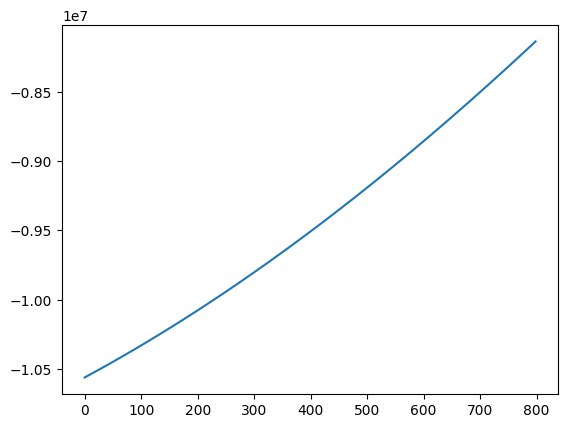

In [88]:
import matplotlib.pyplot as plt
plt.plot(Y.t, Y.y[2])
plt.plot(0,y0[2])
